In [38]:
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
from paper_changes import *
# manual feature selection
from collections import defaultdict
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.decomposition import SparsePCA
from scipy.stats import zscore
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [39]:
class Metrics:
    '''would dod this for test, but don't want to rewrite it'''
    def __init__(self):
        self.recalls = list()
        self.precisions = list()
        self.accuracies = list()
        self.balanced_accuracies = list()
        self.rocs = list()
    
    def add_results(self, actual, preds, probs):
        self.recalls.append(recall_score(actual, preds))
        self.precisions.append(precision_score(actual, preds))
        self.accuracies.append(accuracy_score(actual, preds))
        self.balanced_accuracies.append(balanced_accuracy_score(actual, preds))
        self.rocs.append(roc_auc_score(actual, probs))
    
    def avg_all(self):
        self.avgs = pd.Series({
            'recall': np.mean(self.recalls),
            'precision': np.mean(self.precisions),
            'accuracy': np.mean(self.accuracies),
            'balanced_accuracy': np.mean(self.balanced_accuracies),
            'roc': np.mean(self.rocs)})
        self.recall = self.avgs.recall
        self.precision = self.avgs.precision
        self.accuracy = self.avgs.accuracy
        self.balanced_accuracy = self.avgs.balanced_accuracy
        self.roc = self.avgs.roc

In [40]:
def crossval(X, y, pipe, get_feats, ite=100, verbose=True, null=False):
    feats = defaultdict(list)
    preds = list()
    probs = list()
    model = 'logit'
    trm = Metrics()
    ys = list()
    for _ in tqdm(range(ite)) if verbose else range(ite):
        if null:
            y = y.sample(frac=1)
        ys.extend(y)
        for train_idx, test_idx in LeaveOneOut().split(X):
            pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
            trm.add_results(y.iloc[train_idx],
                pipe.predict(X.iloc[train_idx].values), 
                pipe.predict_proba(X.iloc[train_idx].values).T[:, 1])
            pred = pipe.predict(X.iloc[test_idx].values)[0]
            proba = pipe.predict_proba(X.iloc[test_idx].values).T[0][1]
            preds.append(pred)
            probs.append(proba)
            fs = get_feats(pipe)
            for f in fs.index:
                if abs(fs[f]) > 0:
                    feats[f].append(fs[f])
    bm = pd.DataFrame(list(zip(preds, probs, ys)), 
                      columns=['pred', 'proba', 'actual'])
    trm.avg_all()
    return bm, trm, feats


def print_res(bm, trm, model='logit'):
    rs = recall_score(bm['actual'], bm['pred'])
    ps = precision_score(bm['actual'], bm['pred'])
    acc = accuracy_score(bm['actual'], bm['pred'])
    bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
    roc = roc_auc_score(bm['actual'], bm['proba'])
    
    results = trm.avgs.to_frame().rename(columns={0: 'train'})
    results['test'] = 0
    results.loc['accuracy', 'test'] = acc
    results.loc['balanced_accuracy', 'test'] = bacc
    results.loc['precision', 'test'] = ps
    results.loc['recall', 'test'] = rs
    results.loc['roc', 'test'] = roc
    
    print(results.round(3))
    
    
def plot_res(feats):
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))

    fsrs['count'].apply(lambda v: v/4000).plot(kind='bar', ax=axs[0]);
    axs[0].set_ylabel('Percent of Models w/ Feature')
    fsrs['mean'].plot(kind='bar', yerr=fsrs['std'], ax=axs[1])
    axs[1].set_ylabel('Avg Model Weight')

    sns.despine()

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


                   train   test
accuracy           0.813  0.780
balanced_accuracy  0.811  0.774
precision          0.840  0.792
recall             0.825  0.826
roc                0.874  0.758
           mean       std  count
pc_1   0.056643  0.021148     41
pc_10  0.391598  0.003991      2
pc_2   0.122499  0.044751     41
pc_3  -0.601435  0.182368     41
pc_4   0.175330  0.107682     40
pc_5  -0.403693  0.414317      3
pc_6  -1.109648  0.196190     40
pc_8   0.299287  0.000000      1


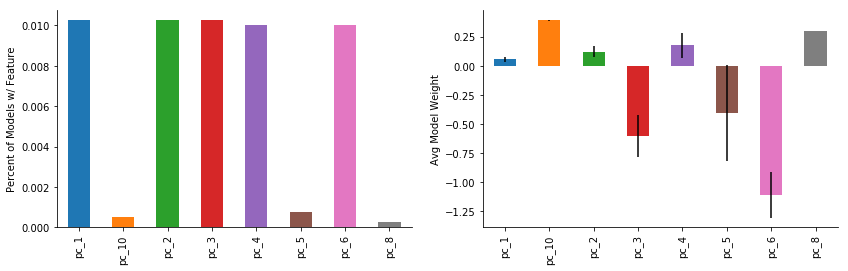

In [6]:
X, y = load_data()

pipe = Pipeline([('clf', LogisticRegression(C=0.75, penalty='l1', class_weight='balanced', solver='liblinear',
                                                max_iter=100))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[-1][1].coef_), 
                                   index=['pc_' + str(i+1) for i in range(X.shape[1])])

bm, trm, feats = crossval(X, y, pipe, get_feats, ite=1)

print_res(bm, trm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

## Testing

In [41]:
from group_lasso import LogisticGroupLasso

In [42]:
def col_to_band_group(band):
    if 'delta' in band:
        return 1
    elif 'theta' in band:
        return 2
    elif 'alpha' in band:
        return 3
    elif 'beta' in band:
        return 4
    elif 'gammaL' in band:
        return 5
    elif 'gammaH' in band:
        return 6
    else:
        raise ValueError('No band present')

band_groups = [col_to_band_group(col) for col in X.columns]
community_groups = [int(col[-1])+1 for col in X.columns]

In [43]:
X, y = load_data()

gl = LogisticGroupLasso(
    groups=community_groups,
    group_reg=0.01,
    l1_reg=0.00,
)

gl.fit(X, y)

pred_y = gl.predict(X.values)
sparsity_mask = gl.sparsity_mask_
coefs = gl.coef_[:, 1] - gl.coef_[:, 0]
accuracy = (np.squeeze(pred_y) == y).mean()

print(f"Number variables: {len(sparsity_mask)}")
print(f"Number of chosen variables: {sparsity_mask.sum()}")
print(f"Accuracy: {accuracy}")

Number variables: 36
Number of chosen variables: 24
Accuracy: 0.8048780487804879


In [9]:
X, y = load_data()

pipe = Pipeline([('clf', LogisticGroupLasso(groups=band_groups, group_reg=0.05, l1_reg=0.05))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[-1][1].coef_[:, 1] - pipe.steps[-1][1].coef_[:, 0]), 
                                   index=X.columns)

bm, trm, feats = crossval(X, y, pipe, get_feats, ite=1)

print_res(bm, trm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


ValueError: Classification metrics can't handle a mix of binary and unknown targets

In [18]:
from sklearn.model_selection import cross_validate

results = cross_validate(pipe, X.values, y, cv=LeaveOneOut())
print(f"mean: {results['test_score'].mean()}, std: {results['test_score'].std()}")

mean: 0.7073170731707317, std: 0.45499410015067393


In [52]:
from sklearn.model_selection import GridSearchCV

parameters = {'group_reg': np.linspace(0, 0.05, 20), 
              'l1_reg': np.linspace(0, 0.05, 20)}
clf = GridSearchCV(LogisticGroupLasso(groups=community_groups), param_grid=parameters,
                   cv=LeaveOneOut())
clf.fit(X.values, y);

In [53]:
pd.DataFrame(clf.cv_results_) \
    [['param_group_reg', 'param_l1_reg', 'mean_test_score', 'std_test_score']] \
    .sort_values('mean_test_score', ascending=False).head(20)

,param_group_reg,param_l1_reg,mean_test_score,std_test_score
160,0.0210526,0,0.731707,0.443071
141,0.0184211,0.00263158,0.731707,0.443071
62,0.00789474,0.00526316,0.731707,0.443071
61,0.00789474,0.00263158,0.731707,0.443071
100,0.0131579,0,0.731707,0.443071
101,0.0131579,0.00263158,0.731707,0.443071
102,0.0131579,0.00526316,0.731707,0.443071
81,0.0105263,0.00263158,0.731707,0.443071
121,0.0157895,0.00263158,0.731707,0.443071
122,0.0157895,0.00526316,0.731707,0.443071
